# DSCI 100 - Proposal
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

The topic of our project is centered around a data set which looks at student performance in two different schools located in Portugal. The dataset includes a variety of different factors that could play a role in student performance. The dataset also tracks first and second period grades as well as final grades in Portugese, which can be used to determine the change in student performance.
A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 
 
We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. This information collected includes student grades, social and study habits, and family background.  The data tracks the students’ grades in two subjects, Mathematics and Portuguese. 
 
We will try to answer the following question in this report:
Can we predict whether a student  pursue higher education,  given sex, address, parent education, class failures, family educational support, and Portuguese grades?


## Preliminary exploratory data analysis

In [2]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [24]:
#Read data set from the web into R
student_port <- read.table("data/student-por.csv",sep=";",header=TRUE)

# Clean and wrangle data into tidy format
student_select <- student_port %>%
        select("sex", "address", "Medu", "Fedu", "failures", "famsup", "higher", "G1", "G2", "G3") %>%
        mutate(higher = as_factor(higher))

# Obtain training set
# o damn we have to reason why we decided to use 0.75. anything >500 is big -> training set has 487 -> use 0.75?
student_split <- initial_split(student_select, prop = 0.75, strata = higher) 
student_train <- training(student_split)
student_train

,sex,address,Medu,Fedu,failures,famsup,higher,G1,G2,G3
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<fct>,<int>,<int>,<int>
1,F,U,4,4,0,no,yes,0,11,11
2,F,U,1,1,0,yes,yes,9,11,11
3,F,U,1,1,0,no,yes,12,13,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
646,F,U,3,1,0,yes,yes,15,15,16
647,F,U,1,1,0,no,yes,11,12,9
648,M,U,3,1,0,no,yes,10,10,10


In [46]:
# number of observations in higher(target variable)
higher_counts <- student_train %>%
        group_by(higher) %>%
        summarize(n=n())   
higher_counts

# average grade of term 1, term 2, and final Portuguese grade
ave_grade <- student_train %>%
        summarize(G1 = mean(G1), G2 = mean(G2), G3 = mean(G3))
ave_grade


`summarise()` ungrouping output (override with `.groups` argument)



higher,n
<fct>,<int>
yes,435
no,52


G1,G2,G3
<dbl>,<dbl>,<dbl>
11.40452,11.52156,11.86242


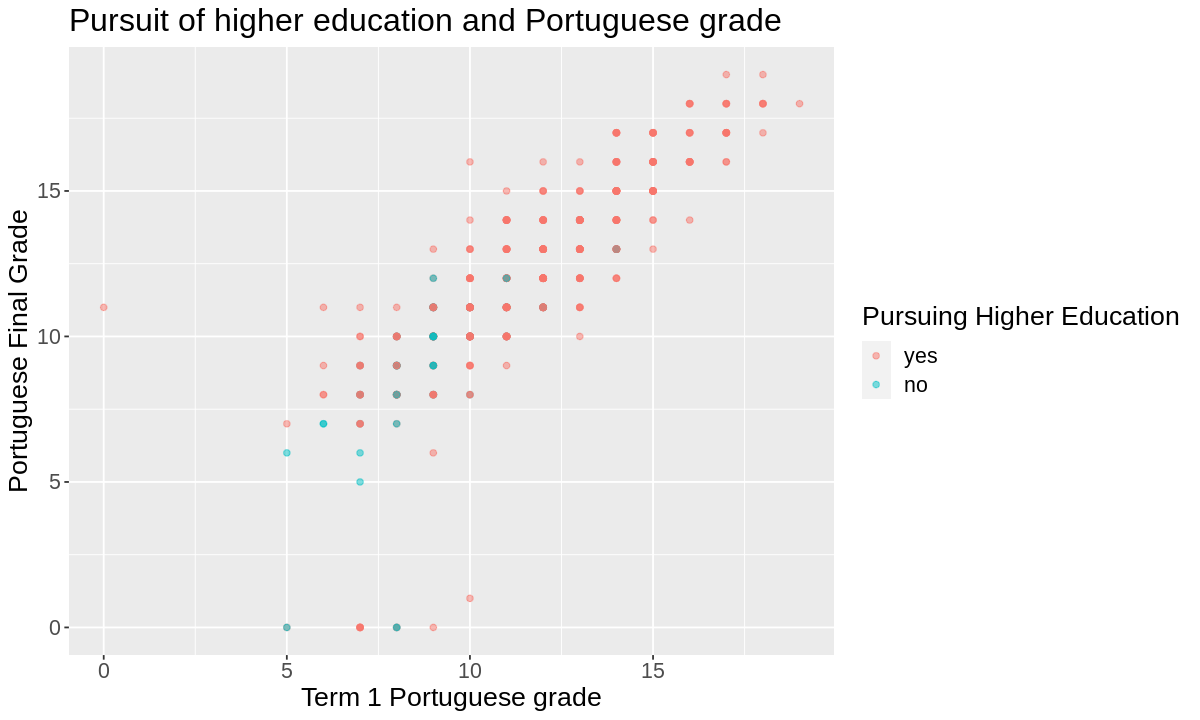

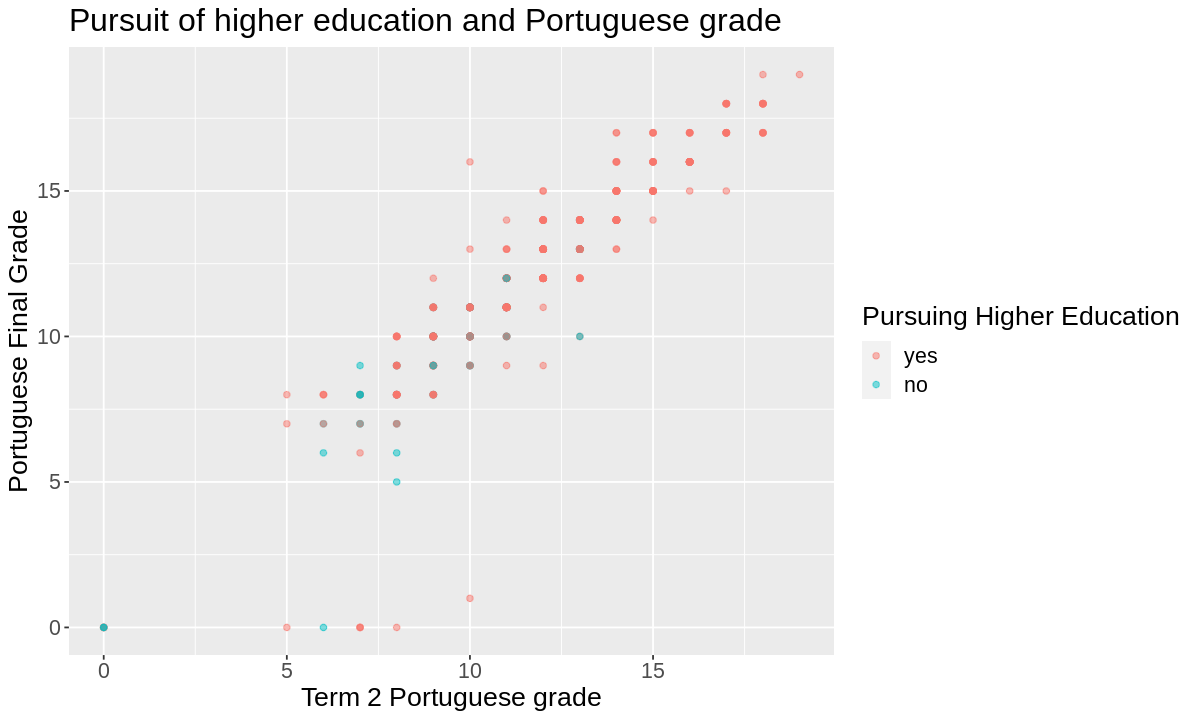

In [47]:
options(repr.plot.width=10, repr.plot.height=6)

# comparing the distribution of Portuguese grades and higher
student_por_plot1 <- student_train %>%
                select(G1, G3, higher) %>%
                ggplot(aes(x = G1, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 1 Portuguese grade", 
                     y = "Portuguese Final Grade", 
                     colour = "Pursuing Higher Education", 
                     title = "Pursuit of higher education and Portuguese grade")+
                theme(text = element_text(size=16))        

student_por_plot2 <- student_train %>%
                select(G2, G3, higher) %>%
                ggplot(aes(x = G2, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 2 Portuguese grade", 
                     y = "Portuguese Final Grade", 
                     colour = "Pursuing Higher Education", 
                     title = "Pursuit of higher education and Portuguese grade")+
                theme(text = element_text(size=16))  

student_por_plot1
student_por_plot2

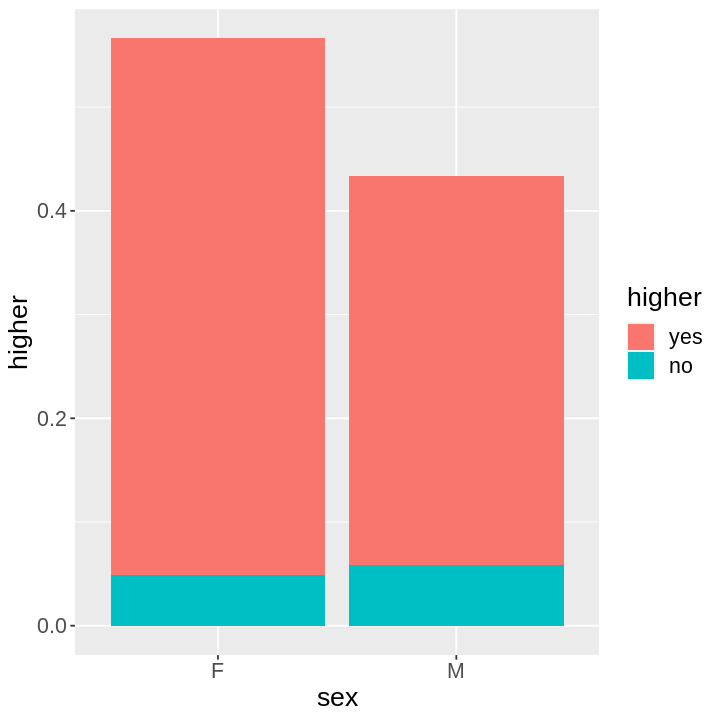

In [6]:
options(repr.plot.width=6, repr.plot.height=6)
student_gender <- student_train %>%
                select(sex, higher) %>%
                ggplot(aes(x=sex, y=higher))+
                geom_bar(aes(y = ..count../sum(..count..), fill = higher))+
                theme(text = element_text(size=16))
student_gender

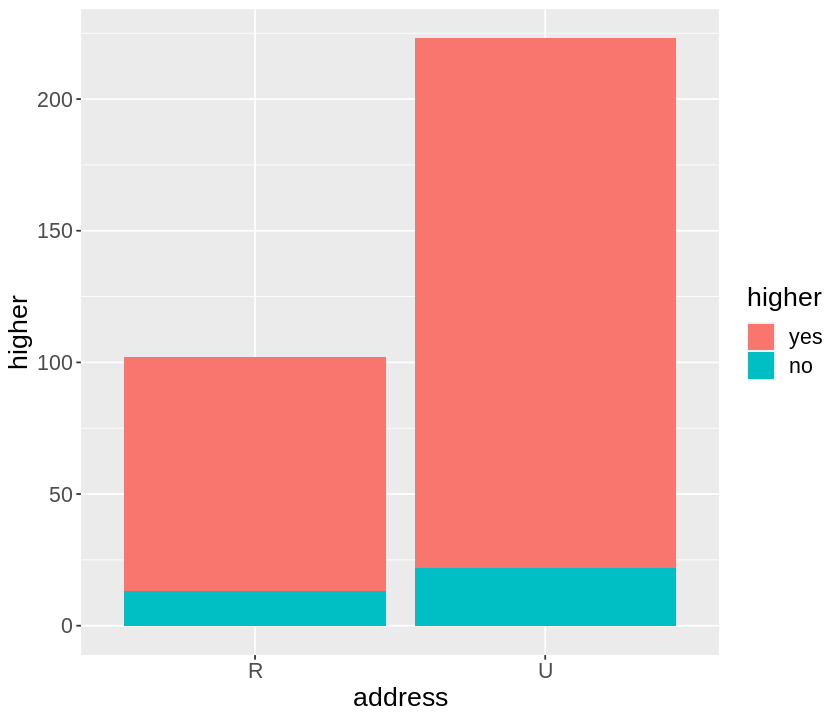

In [7]:
options(repr.plot.width=7, repr.plot.height=6)
student_address <- student_train %>%
                select(address, higher) %>%
                ggplot(aes(x=address, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                theme(text = element_text(size=16))
student_address



`summarise()` regrouping output by 'address' (override with `.groups` argument)



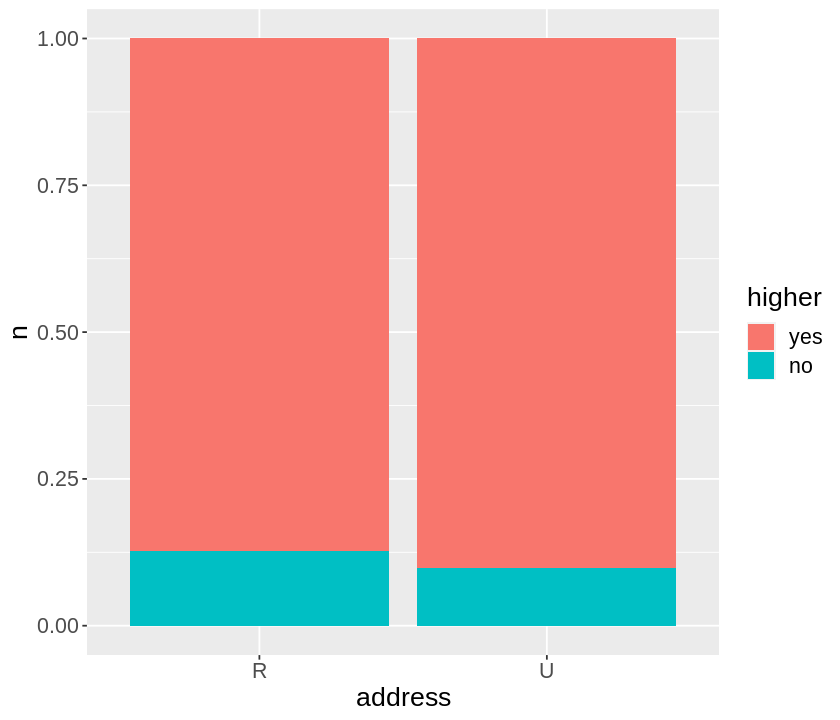

In [8]:
address_n_higher <- student_train %>%
            select(address, higher)%>%
            group_by(address, higher)%>%
            summarize(n = n())
address_plot <- ggplot(address_n_higher, aes(x = address, y = n, fill = higher)) +
                    geom_bar(stat = "identity", position = "fill")+
                theme(text = element_text(size=16))
address_plot

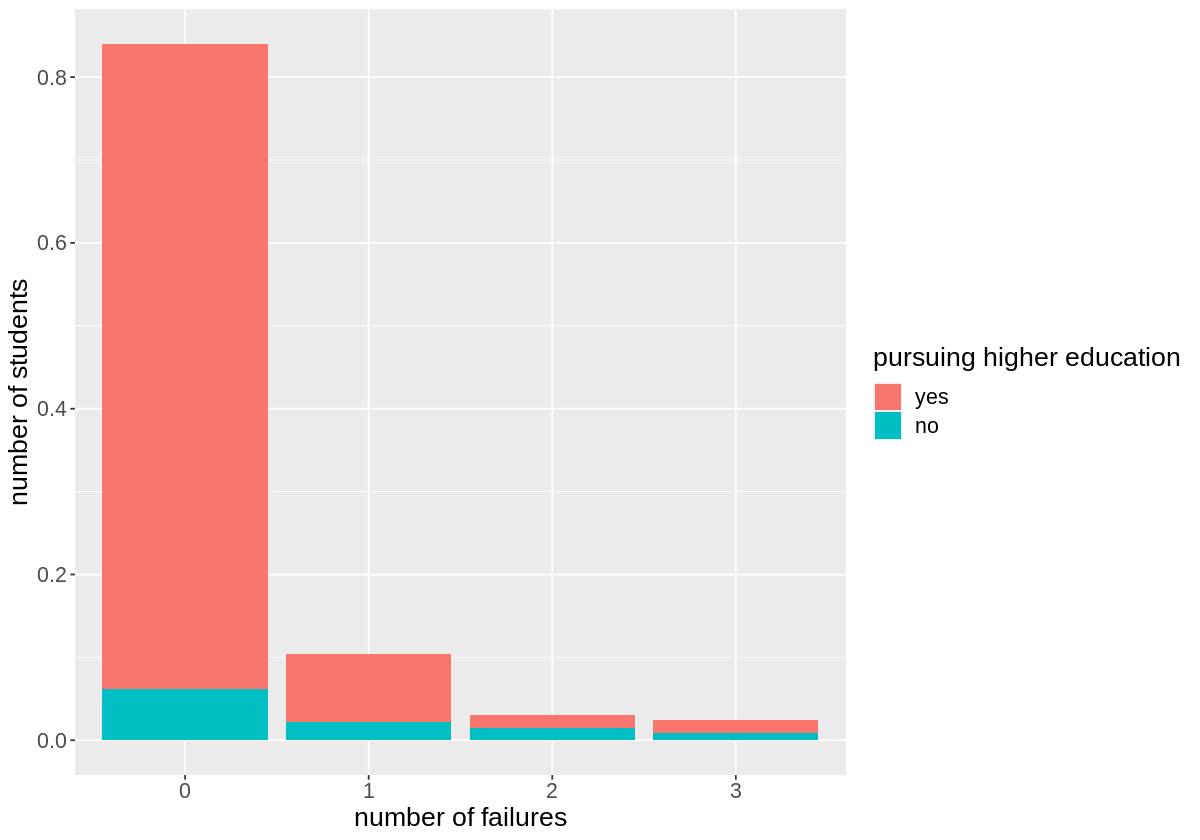

In [9]:
options(repr.plot.width=10, repr.plot.height=7)
student_failures <- student_train %>%
                select(failures, higher) %>%
                ggplot(aes(x=as.factor(failures), y=higher))+
                geom_bar(aes(y = ..count../sum(..count..), fill = higher))+
                labs(y = "number of students", x = "number of failures", fill = "pursuing higher education")+
                theme(text = element_text(size=16))
student_failures

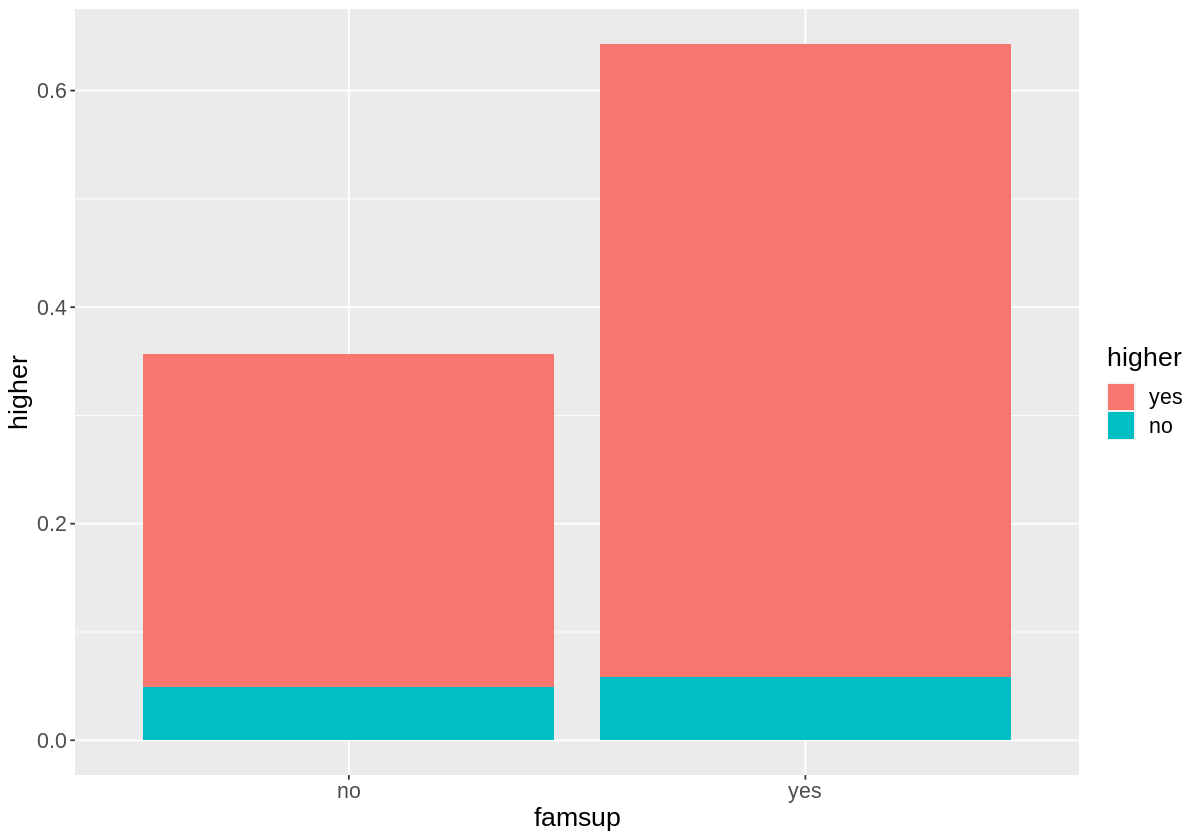

In [10]:
family_support <- student_train %>%
                select(famsup, higher) %>%
                ggplot(aes(x=famsup, y=higher))+
                geom_bar(aes(y = ..count../sum(..count..), fill = higher))+
                theme(text = element_text(size=16))
family_support

## Methods

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Proin et tristique nisi. Praesent euismod eros sit amet iaculis commodo. Nullam eget porta elit. Donec sed eros mi. Curabitur elit purus, tempor eget volutpat vel, faucibus et diam. Aliquam vulputate tortor dolor, a ultricies tortor rutrum ut. Etiam laoreet sed nunc sed tincidunt. Sed vel suscipit ipsum. Donec sodales sit amet ante sit amet luctus.

In aliquam turpis nisl, vel suscipit metus volutpat vel. Maecenas congue, orci at mollis interdum, risus ligula accumsan tortor, ut condimentum lorem leo ut elit. Nullam sit amet purus vel nisi tempus facilisis. Nunc in eros mauris. Praesent non sem sed tellus faucibus lacinia eget sed nulla. Ut lobortis lectus nec quam fringilla, vel fringilla urna euismod. Aenean pellentesque metus quam, id posuere urna sagittis vel. Nunc eu justo non quam imperdiet gravida. Donec dapibus sapien magna, non congue est euismod ut. Nam ut lacus quis orci tincidunt laoreet eget quis libero. Vestibulum aliquet lacus et quam molestie, volutpat blandit metus accumsan. Sed ante nunc, tincidunt sed interdum a, varius eget odio.

## Expected outcomes and significance:

Vestibulum metus nibh, maximus eu metus a, varius scelerisque erat. Cras sed ligula pretium dui imperdiet elementum. Etiam et finibus tortor, ac ornare massa. Ut sagittis hendrerit mattis. Donec eleifend placerat tempus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Fusce non turpis et mauris ultrices hendrerit. Maecenas tincidunt nec leo et accumsan. Cras sagittis erat quis aliquam eleifend. Vestibulum cursus ligula nunc, ut congue nisl laoreet a. Phasellus lobortis sit amet mauris at posuere. Donec gravida libero vel risus aliquet, eget facilisis lacus luctus. Curabitur tincidunt lacus ut pulvinar semper. Maecenas a eros sit amet velit finibus ultricies sit amet sed quam. Morbi lacinia diam id cursus commodo.

Mauris sagittis sed dolor et tempor. Phasellus magna purus, ultrices vel dui id, condimentum rutrum diam. Suspendisse ipsum elit, efficitur ut rutrum at, cursus in eros. Proin felis nisi, luctus in tincidunt at, hendrerit id ex. Etiam sit amet feugiat neque. Vivamus pellentesque maximus metus, id congue tellus blandit sed. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Aenean ut nunc arcu. Suspendisse in lorem venenatis, rutrum arcu vel, lobortis leo. Pellentesque malesuada enim augue, at vulputate arcu consectetur eu. Aliquam blandit in justo vitae gravida. Donec vulputate ut nisl at pharetra.